In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hopsworks
import os
import joblib
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import shutil
from sklearn.model_selection import train_test_split as tts, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [22]:
os.mkdir('assets')

In [2]:
proj = hopsworks.login()
fs = proj.get_feature_store()

try:
    feature_view = fs.get_feature_view(name='bank_notes_dataframe', version=1)
except:
    bank_auth_fg = fs.get_feature_group(name='bank_notes_dataframe', version=1)
    query = bank_auth_fg.select_all()
    feature_view = fs.create_feature_view(name='bank_notes_dataframe',
                                         version = 1,
                                         description = 'Read from bank-note dataset',
                                         labels = ['output'],
                                         query = query)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/39062
Connected. Call `.close()` to terminate connection gracefully.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/39062/fs/38982/fv/bank_notes_dataframe/version/1


In [3]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size = 0.3)

2023-05-01 18:57:32,995 INFO: USE `bwhiz_featurestore`
2023-05-01 18:57:33,773 INFO: SELECT `fg0`.`variance` `variance`, `fg0`.`skewness` `skewness`, `fg0`.`curtosis` `curtosis`, `fg0`.`entropy` `entropy`, `fg0`.`output` `output`
FROM `bwhiz_featurestore`.`bank_notes_dataframe_1` `fg0`


In [8]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [11]:
xgb_cls = XGBClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

acc = []
roc = []
for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.loc[train_idx], X_train.loc[val_idx]
    y_train_fold, y_val_fold = y_train.loc[train_idx], y_train.loc[val_idx] 
    xgb_cls.fit(X_train_fold, y_train_fold)
    y_pred = xgb_cls.predict(X_val_fold)
    y_prob = xgb_cls.predict_proba(X_val_fold)
    acc_score = accuracy_score(y_val_fold, y_pred)
    roc_score = roc_auc_score(y_val_fold, y_prob[:,1])
    acc.append(acc_score)
    roc.append(roc_score)
print(f'The Accuracy is {acc}')
print(f'The ROC is {roc}')
print(f'Mean Accuracy is {np.mean(acc):.4f}')
print(f'Mean ROC is: {np.mean(roc):.4f}')

The Accuracy is [0.9947089947089947, 0.9841269841269841, 0.9947089947089947, 0.9893617021276596, 0.9946808510638298]
The ROC is [1.0, 0.9997726756080927, 1.0, 0.9995410212277681, 0.9994247583985273]
Mean Accuracy is 0.9915
Mean ROC is: 0.9997


In [12]:
prediction = xgb_cls.predict(X_test)

In [26]:
metrics = classification_report(y_test, prediction,output_dict=True)
print(metrics)

{'0': {'precision': 1.0, 'recall': 0.9952153110047847, 'f1-score': 0.9976019184652278, 'support': 209}, '1': {'precision': 0.9949238578680203, 'recall': 1.0, 'f1-score': 0.9974554707379135, 'support': 196}, 'accuracy': 0.9975308641975309, 'macro avg': {'precision': 0.9974619289340101, 'recall': 0.9976076555023923, 'f1-score': 0.9975286946015707, 'support': 405}, 'weighted avg': {'precision': 0.9975433978818073, 'recall': 0.9975308641975309, 'f1-score': 0.9975310449971941, 'support': 405}}


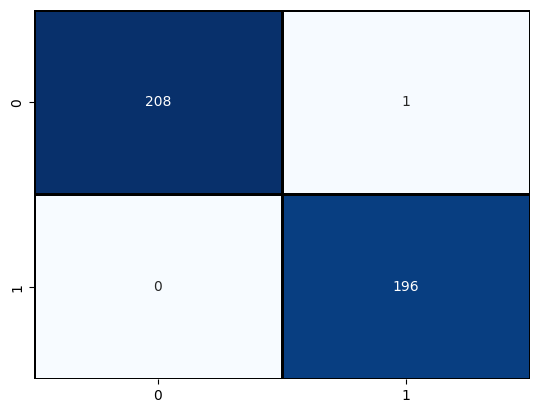

In [23]:
cm = sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='',
            linecolor='k',linewidths=1,cmap='Blues',cbar=False)

fig = cm.get_figure()
fig.savefig('assets/confusion_matrix.png')
fig.show();

### Registering the Model with Hopsworks Model Registry

In [31]:
project = hopsworks.login()
mr = project.get_model_registry()

model_dir = 'bank_note_model'
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(xgb_cls, model_dir + '/bank_note_model.pkl')
shutil.copyfile('assets/confusion_matrix.png', model_dir + '/confusion_matrix.png')

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

bank_note_model = mr.python.create_model(version=1,
                                    name = 'bank_note',
                                    metrics = {'accuracy' : metrics['accuracy']},
                                    model_schema = model_schema,
                                    input_example = input_example,
                                    description = 'Bank note authenticator'
)

bank_note_model.save(model_dir)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/39062
Connected. Call `.close()` to terminate connection gracefully.


ModelRegistryException: Model with name bank_note and version 1 already exists